In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import pickle
import glob
import datetime
from os import path
from matplotlib.tri import Triangulation
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
def get_membership_integral(f,ext = 3.,N = 500):
    resg = 2. * ext / N
    with open(f,'rb') as fid:
        data = pickle.load(fid,encoding='latin-1')
    ctime = data['runtime']
    del data['runtime']
    xg,yg = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
    rg = np.sqrt(xg**2. + yg**2.)
    tg = np.arctan2(xg,yg) * 180./np.pi
    tg[tg < -90.] += 360.
    z = np.zeros_like(xg) * np.nan
    for ind,n in enumerate(sorted(list(data.keys()))[::-1]):
        xy = data[n]['xy'][len(data[n]['xy']) - 1][:,0]
        r = np.sqrt(xy.real**2. + xy.imag**2.)
        theta = np.arctan2(xy.real,xy.imag) * 180./np.pi
        theta[theta < -90] += 360.
        #try:
        trif = Triangulation(r,theta).get_trifinder()
        for j in range(N):
            for i in range(N):
                if trif(rg[j,i],tg[j,i]) != -1:
                    z[j,i] = ind / (len(data) + 1)
        #except:
            #if len(r) == 1:
            #    d = np.sqrt((xg - xy.real)**2. + (yg - xy.imag)**2.)
            #    j,i = np.where(d == np.nanmin(d))
            #    z[j[0],i[0]] = ind / (len(data) + 1)
            #else:
            #print('Something unexpected happened with the triangulation for %s on level %.2f'%(f.split('/')[-1],ind))
            #return np.nan
    z = z * resg**2.
    
    return np.nansum(z),ctime

C:\Users\hauke\AppData\Local\Temp/ipykernel_22180/753557691.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crisp_solution = np.complex(x,y)


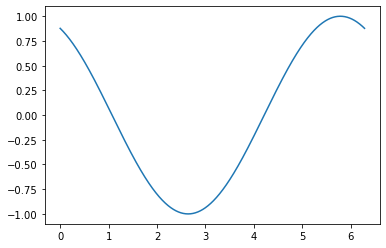

In [3]:
t = np.linspace(0.,2.*np.pi,1000)
f = np.cos(t + 0.5)
integral = np.sum(0.5 * (f[:-1] + f[1:]) / np.mean(np.diff(t)))
y = np.cos(integral)
x = np.sin(integral)
crisp_solution = np.complex(x,y)
plt.plot(t,f)

In [4]:
crisp_files = sorted(glob.glob('D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/*_npg1_npl1_fd10.pickle'))
#crisp_files = sorted(glob.glob('D:/rerun_sensitivity_202209/wave_results/*_npg1_npl1_fd10.pickle'))
cskill = []
for f in crisp_files:
    attribs = f.split('\\')[-1].split('_')[1:]
    dt = float(attribs[0][2:])
    res = float(attribs[1][3:]) / 1000.
    if res == 0.2:
        continue
    with open(f,'rb') as fid:
        data = pickle.load(fid)
    f_xy = data[0.]['xy'][len(data[0.]['xy']) - 1][0,0]
    s = np.absolute(f_xy - crisp_solution)
    skill = np.max([0.,1. - s])
    cskill.append([dt,res,skill])
cskill = np.asarray(cskill)

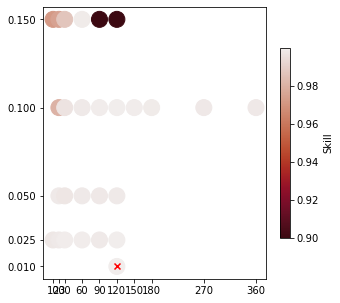

In [5]:
fig,ax = plt.subplots(figsize=(5,5))
pc = ax.scatter(cskill[:,0],cskill[:,1],c=cskill[:,2],cmap=cm.amp_r,s=256,vmin=0.9)
fig.colorbar(pc,orientation='vertical',shrink=0.7,label='Skill')
_=ax.set_xticks(np.unique(cskill[:,0]))
_=ax.set_yticks(np.unique(cskill[:,1]))
c = np.where(cskill[:,2] == np.nanmax(cskill[:,2]))[0][0]
ax.scatter(cskill[c,0],cskill[c,1],color='r',marker='x')

In [ ]:
#files = sorted(glob.glob('D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/fuzzyTrial_*.pickle'))
files = sorted(glob.glob('D:/rerun_sensitivity_202209/wave_results/fuzzyTrial_*.pickle'))

params = []
for f in files:
    attribs = f.split('\\')[-1].split('_')[1:]
    dt = float(attribs[0][2:])
    res = float(attribs[1][3:]) / 1000.
    if res == 0.2:
        continue
    npg = int(attribs[2][3:])
    npl = int(attribs[3][3:])
    fd = float(attribs[4].split('.')[0][2:]) / 10.
    if fd == 1.:
        continue
    Iu,ctime = get_membership_integral(f)
    params.append([dt,res,npg,npl,fd,Iu,ctime])
    
fsave = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_params_npg64.pickle'

with open(fsave,'wb',-1) as fid:
    pickle.dump(params,fid)

In [5]:
with open('D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_params.pickle','rb') as fid:
    params = pickle.load(fid)

TypeError: list indices must be integers or slices, not tuple

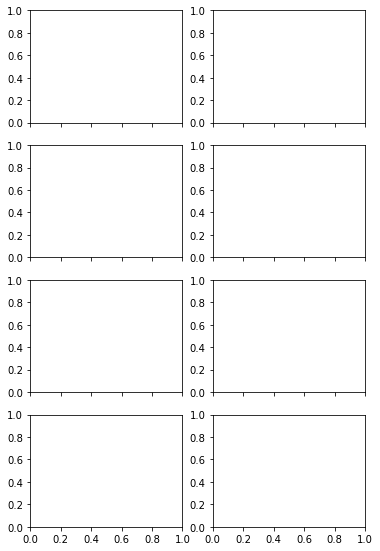

In [7]:
fig,axes = plt.subplots(4,2,sharex='col',figsize=(6,9.5))

for axI,npg,npl in zip(range(axes.shape[0]),[16.,32.,64.,64.],[9.,9.,9.,9.]):
    ax = axes[axI,:]
    c = np.where(np.logical_and(params[:,0] == 270.,
                                np.logical_and(params[:,2] == npg,
                                               np.logical_and(params[:,3] == npl,params[:,4] == 1.3))))[0]
    ax[0].scatter(params[c,1],params[c,5],c=params[c,4],cmap=cm.phase,vmin=1.,vmax=2.)
    ax[1].scatter(params[c,1],params[c,6],c=params[c,4],cmap=cm.phase,vmin=1.,vmax=2.)
    ax[1].axhline(1800.,color='k',ls='--')
    ax[1].set_yscale('log')

In [8]:
from scipy.stats import linregress

In [9]:
dt = 120.
npg = 32.
npl = 7.

for fd in [1.1,1.3,1.5,1.7,2.]:
    c = np.where(np.logical_and(params[:,0] == 120.,
                                np.logical_and(params[:,2] == npg,
                                               np.logical_and(params[:,3] == npl,params[:,4] == fd))))[0]
    res = params[c,1]
    fuzz = params[c,5]
    slo,inte,r,p,sloerr = linregress(res,fuzz)
    print(fd,slo,inte,r,p,sloerr)

TypeError: list indices must be integers or slices, not tuple

In [6]:
params = np.asarray(params)
acskill = np.zeros([params.shape[0],])
for i in range(params.shape[0]):
    dt = params[i,0]
    res = params[i,1]
    c = np.where(np.logical_and(cskill[:,0] == dt,cskill[:,1] == res))[0]
    if len(c) > 0:
        acskill[i] = cskill[c[0],2]
    else:
        acskill[i] = np.nan

In [7]:
#cost = np.zeros([params.shape[0],])
Frat = np.zeros([params.shape[0],])
Trat = np.zeros([params.shape[0],])
for fd in [1.1,1.3,1.5,1.7,2.]:
    c = np.where(params[:,4] == fd)[0]
    Frat[c] = 1. - params[c,5] / params[c,5].max()
    Trat[c] = params[c,6] / params[c,6][params[c,5] == params[c,5].max()]
cost = 0.5 * acskill * (Frat + Trat)
cost[Trat > 1.] = np.nan

Frat[Trat > 1.] = np.nan
acskill[Trat > 1.] = np.nan
Trat[Trat > 1.] = np.nan

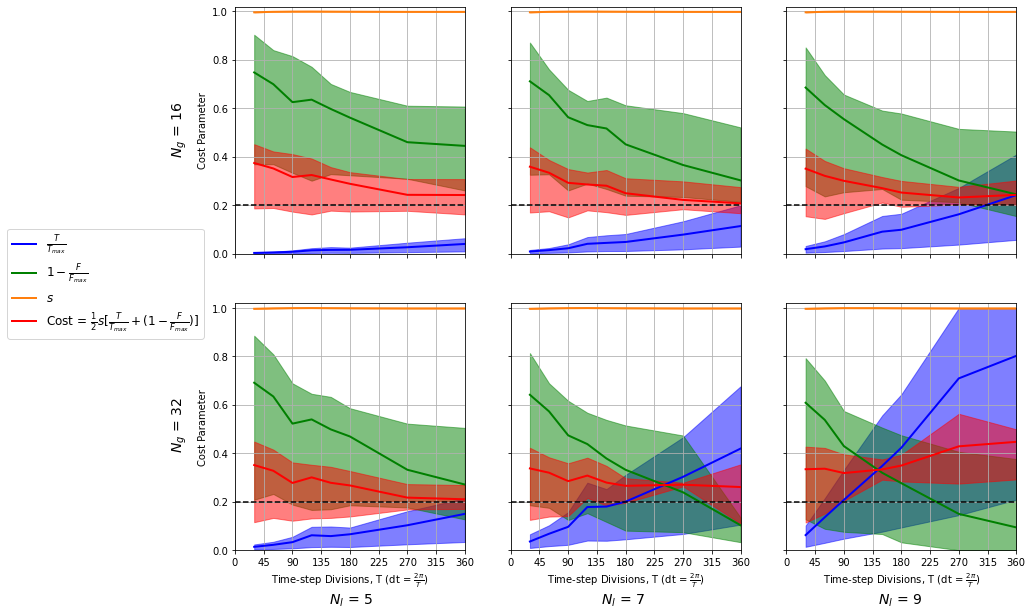

In [11]:
dts = sorted(np.unique(params[:,0]))

fig,axes = plt.subplots(2,3,sharex='col',sharey='row',figsize=(14,10))
for j,ng in enumerate([16,32]):
    for i,nl in enumerate([5,7,9]):
        ax = axes[j,i]
        flag = True
        for dt in dts:
            c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == 0.100),
                                       np.logical_and(params[:,2] == ng,params[:,3] == nl)))[0]
            if len(c) == 0 or dt <= 25.:#or dt == 15.:
                TT = np.array([np.nan,np.nan,np.nan])
                FF = np.array([np.nan,np.nan,np.nan])
                ss = np.array([np.nan,np.nan,np.nan])
                cc = np.array([np.nan,np.nan,np.nan])
            else:
                TT = np.array([np.nanmean(Trat[c]),np.nanmin(Trat[c]),np.nanmax(Trat[c])])
                FF = np.array([np.nanmean(Frat[c]),np.nanmin(Frat[c]),np.nanmax(Frat[c])])
                ss = np.array([np.nanmean(acskill[c]),np.nanmin(acskill[c]),np.nanmax(acskill[c])])
                cc = np.array([np.nanmean(cost[c]),np.nanmin(cost[c]),np.nanmax(cost[c])])
            if flag:
                T = TT
                F = FF
                s = ss
                co = cc
                flag = False
            else:
                T = np.vstack([T,TT])
                F = np.vstack([F,FF])
                s = np.vstack([s,ss])
                co = np.vstack([co,cc])

        for arr in [T,F,s,co]:
            c = np.where(np.isnan(arr[:,0]))[0]
            for cc in c:
                arr[cc,:] = 0.5 * (arr[cc-1,:] + arr[cc+1,:])
                
        for arr,col in zip([T,F,s,co],['b','g','tab:orange','r']):
            ax.fill_between(dts,arr[:,1],arr[:,2],color=col,alpha=0.5)
            ax.plot(dts,arr[:,0],color=col,lw=2)
        
        ax.axhline(0.2,color='k',ls='--')
        ax.grid(which='both')
        ax.set_xticks(np.arange(0.,361.,45.))
        ax.set_xlim(0.,360.)
        ax.set_ylim(0.,1.02)
        
        if i == 0:
            ax.set_ylabel('Cost Parameter')
        if j == 1:
            ax.set_xlabel(r'Time-step Divisions, T (dt = $\frac{2\pi}{T}$)')

handles = [Line2D([],[],color=col,lw=2) for col in ['b','g','tab:orange','r']]
labels = [r'$\frac{T}{T_{max}}$',r'$1 - \frac{F}{F_{max}}$',r'$s$',
          r'Cost = $\frac{1}{2}s[\frac{T}{T_{max}} + (1 - \frac{F}{F_{max}})]$']
fig.legend(handles,labels,bbox_to_anchor=[0.1,0.58],fontsize=12)

fig.text(0.07,0.71,r'$N_g$ = 16',ha='center',va='center',rotation=90.,fontsize=14)
fig.text(0.07,0.3,r'$N_g$ = 32',ha='center',va='center',rotation=90.,fontsize=14)
fig.text(0.24,0.055,r'$N_l$ = 5',ha='center',va='center',fontsize=14)
fig.text(0.51,0.055,r'$N_l$ = 7',ha='center',va='center',fontsize=14)
fig.text(0.785,0.055,r'$N_l$ = 9',ha='center',va='center',fontsize=14)

plt.savefig('D:/iCloudDrive/Thesis/Figures/fig7_unsteadyCost.png',dpi=450,bbox_inches='tight')
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig7_unsteadyCost.svg',bbox_inches='tight')

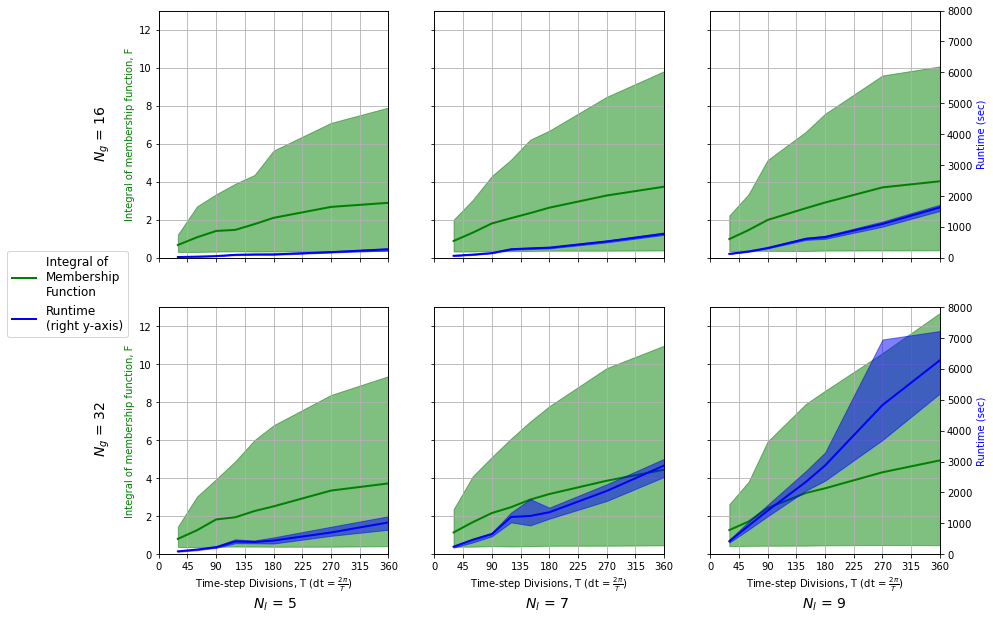

In [10]:
dts = sorted(np.unique(params[:,0]))

fig,axes = plt.subplots(2,3,sharex='col',sharey='row',figsize=(14,10))
for j,ng in enumerate([16,32]):
    for i,nl in enumerate([5,7,9]):
        ax = axes[j,i]
        flag = True
        for dt in dts:
            c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == 0.100),
                                       np.logical_and(params[:,2] == ng,params[:,3] == nl)))[0]
            if len(c) == 0 or dt <= 25.:# or dt == 15.:
                TT = np.array([np.nan,np.nan,np.nan])
                FF = np.array([np.nan,np.nan,np.nan])
            else:
                TT = np.array([np.nanmean(params[c,6]),np.nanmin(params[c,6]),np.nanmax(params[c,6])])
                FF = np.array([np.nanmean(params[c,5]),np.nanmin(params[c,5]),np.nanmax(params[c,5])])
            if flag:
                T = TT
                F = FF
                flag = False
            else:
                T = np.vstack([T,TT])
                F = np.vstack([F,FF])

        for arr in [T,F]:
            c = np.where(np.isnan(arr[:,0]))[0]
            for cc in c:
                arr[cc,:] = 0.5 * (arr[cc-1,:] + arr[cc+1,:])
        
        ax2 = ax.twinx()
        for a,arr,col in zip([ax,ax2],[F,T],['g','b']):
            a.fill_between(dts,arr[:,1],arr[:,2],color=col,alpha=0.5)
            a.plot(dts,arr[:,0],color=col,lw=2)
        
        ax.grid(which='both')
        ax.set_xticks(np.arange(0.,361.,45.))
        ax.set_xlim(0.,360.)
        ax2.set_ylim(0.,8000.)
        
        if i == 0:
            ax.set_ylabel('Integral of membership function, F',color='g')
            ax.set_ylim(0.,13.)
            ax2.set_yticks([])
        if i == 1:
            ax2.set_yticks([])
        if i == 2:
            ax2.set_ylabel('Runtime (sec)',color='b')
        if j == 1:
            ax.set_xlabel(r'Time-step Divisions, T (dt = $\frac{2\pi}{T}$)')

handles = [Line2D([],[],color=col,lw=2) for col in ['g','b']]
labels = ['Integral of\nMembership\nFunction','Runtime\n(right y-axis)']
fig.legend(handles,labels,bbox_to_anchor=[0.1,0.555],fontsize=12)

fig.text(0.07,0.71,r'$N_g$ = 16',ha='center',va='center',rotation=90.,fontsize=14)
fig.text(0.07,0.3,r'$N_g$ = 32',ha='center',va='center',rotation=90.,fontsize=14)
fig.text(0.24,0.055,r'$N_l$ = 5',ha='center',va='center',fontsize=14)
fig.text(0.51,0.055,r'$N_l$ = 7',ha='center',va='center',fontsize=14)
fig.text(0.785,0.055,r'$N_l$ = 9',ha='center',va='center',fontsize=14)

plt.savefig('D:/iCloudDrive/Thesis/Figures/fig6_unsteadyAbsolute.png',dpi=450,bbox_inches='tight')
plt.savefig('D:/iCloudDrive/Thesis/Figures/fig6_unsteadyAbsolute.svg',bbox_inches='tight')

In [12]:
params[params[:,2] == 64,:]

array([[2.70000000e+02, 1.00000000e-01, 6.40000000e+01, 1.10000000e+01,
        1.30000000e+00, 1.74919680e+00, 2.79269780e+04],
       [2.70000000e+02, 1.00000000e-01, 6.40000000e+01, 5.00000000e+00,
        1.30000000e+00, 9.27302400e-01, 2.88310462e+03],
       [2.70000000e+02, 1.00000000e-01, 6.40000000e+01, 7.00000000e+00,
        1.30000000e+00, 9.97747200e-01, 7.08634347e+03],
       [2.70000000e+02, 1.00000000e-01, 6.40000000e+01, 9.00000000e+00,
        1.30000000e+00, 1.13417280e+00, 1.54832039e+04]])

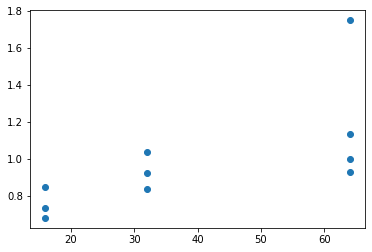

In [17]:
c = np.where(np.logical_and(np.logical_and(params[:,0] == 270.,params[:,1] == 0.1),params[:,4] == 1.3))[0]
plt.scatter(params[c,2],params[c,5])

In [ ]:
NPG = np.unique(params[:,2])
NPL = np.unique(params[:,3])
particle_grid = np.zeros([len(NPG),len(NPL)])
for j,npg in enumerate(NPG):
    for i,npl in enumerate(NPL):
        c = np.where(np.logical_and(params[:,2] == npg,params[:,3] == npl))[0]
        particle_grid[j,i] = np.nanmean(cost[c])
        
x,y = np.meshgrid(NPL,NPG)
fig,ax = plt.subplots(figsize=(7,5))
pc = ax.scatter(x,y,c=particle_grid,cmap=cm.amp,marker='o',s=1024)
plt.colorbar(pc,orientation='vertical',shrink=0.7,label='Cost')
ax.set_xticks([t for t in NPL])
ax.set_yticks([t for t in NPG])
ax.set_xlabel('Local Particles')
ax.set_ylabel('Global Particles')
ax.grid(which='both')

In [ ]:
DT = np.unique(params[:,0])
RES = np.unique(params[:,1])
res_grid = np.zeros([len(RES),len(DT)])
for j,res in enumerate(RES):
    for i,dt in enumerate(DT):
        c = np.where(np.logical_and(params[:,0] == dt,params[:,1] == res))[0]
        res_grid[j,i] = np.nanmean(cost[c])
        
x,y = np.meshgrid(RES,DT)
fig,ax = plt.subplots(figsize=(7,5))
pc = ax.scatter(x,y,c=res_grid,cmap=cm.amp,marker='o',s=1024)#,vmax=3.)
plt.colorbar(pc,orientation='vertical',shrink=0.7,label='Cost')
ax.set_xticks([t for t in RES])
ax.set_yticks([t for t in DT])
ax.set_ylabel(r'Time Step, dt (2$\pi$/dt sec)')
ax.set_xlabel('Spatial Resolution')
ax.grid(which='both')

In [ ]:
DT = np.unique(params[:,0])
RES = np.unique(params[:,1])
print(RES)
NPG = np.unique(params[:,2])
NPL = np.unique(params[:,3])
fig,axes = plt.subplots(len(NPG),len(NPL),sharex = 'col',sharey = 'row',figsize=(14,10))

for aj,npg in enumerate(NPG):
    for ai,npl in enumerate(NPL):
        ax = axes[aj,ai]
        x,y = np.meshgrid(RES,DT)
        res_grid = np.zeros_like(x)
        for i,res in enumerate(RES):
            for j,dt in enumerate(DT):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                           np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                res_grid[j,i] = np.nanmean(cost[c])

        pc = ax.scatter(x,y,c=res_grid,cmap=cm.amp,vmin=0.,vmax=1.,marker='o',s=512)
        jm,im = np.where(res_grid == np.nanmin(res_grid))
        ax.scatter(x[jm,im],y[jm,im],c='r',marker='x',s=512)
        ax.set_xticks([t for t in RES])
        ax.set_yticks([t for t in DT])
        #ax.set_ylabel(r'Time Step, dt (2$\pi$/dt sec)')
        #ax.set_xlabel('Spatial Resolution')
        ax.grid(which='both')
        
for xl,npl in zip([0.2,0.4,0.6,0.8],NPL):
    fig.text(xl,0.08,'nPl = %1i'%npl,ha='center',va='center',fontsize=12)
    
for yl,npg in zip([0.25,0.5,0.75],NPG):
    fig.text(0.1,yl,'nPg = %1i'%npg,ha='center',va='center',fontsize=12,rotation=90.)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fd_avg_cost = np.zeros_like(cost)
for dt in np.unique(params[:,0]):
    for res in np.unique(params[:,1]):
        for npg in np.unique(params[:,2]):
            for npl in np.unique(params[:,3]):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                            np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                if len(c) > 0:
                    fd_avg_cost[c] = np.nanmean(cost[c])
                
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

Cg = (2.*np.pi / params[:,0]) / params[:,1]
z = np.array([np.log2(n) for n in params[:,2]])
ax.scatter(Cg,params[:,3],z,s=1./fd_avg_cost,c=1./fd_avg_cost,cmap=cm.amp,alpha=0.8,vmin=0.,vmax=1./fd_avg_cost.min(),zorder=1000)
ccm = np.where(fd_avg_cost[fd_avg_cost != 0.] == np.nanmin(fd_avg_cost[fd_avg_cost !=0.]))[0][-1]
print(params[ccm,:])
ax.scatter(Cg[ccm],params[ccm,3],z[ccm],s=1./np.nanmin(fd_avg_cost[fd_avg_cost !=0.]),marker='v',color='r',zorder=1001)
ax.text(Cg[ccm],params[ccm,3],z[ccm],
        '   (%.1i,%.2f,%.1i,%.1i)'%(params[ccm,0],params[ccm,1],params[ccm,2],params[ccm,3]),fontsize=18,color='r')
ax.set_yticks([5.,7.,9.,11.])
ax.set_zticks(np.arange(4.,7.,1.))
ax.set_xlabel('CFL #')
ax.set_ylabel('nPl')
ax.set_zlabel('log2(nPg)')

In [ ]:
f = 'D:/iCloudDrive/Thesis/rerun_sensitivity_202209/wave_results/fuzzyTrial_dt10_res150_npg16_npl5_fd13.pickle'

with open(f,'rb') as fid:
    data = pickle.load(fid)
    print(data['runtime'])

In [ ]:
cskill[np.logical_and(cskill[:,0] == 10.,cskill[:,1] == 0.15),2]

In [ ]:
crisp_cfl = (2.*np.pi / cskill[:,0]) / cskill[:,1]
plt.scatter(2.*np.pi / cskill[:,0],cskill[:,1]*100.,c=cskill[:,2],cmap=cm.amp,vmin=0.98,vmax=1.,s=48)
plt.scatter(2.*np.pi / cskill[cskill[:,2] == cskill[:,2].max(),0],
            cskill[cskill[:,2] == cskill[:,2].max(),1]*100.,marker='x',lw=2,color='r')

In [ ]:
#fuzziness as function of parameter space
fd_avg_cost = np.zeros_like(cost)
for dt in np.unique(params[:,0]):
    for res in np.unique(params[:,1]):
        for npg in np.unique(params[:,2]):
            for npl in np.unique(params[:,3]):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                            np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                if len(c) > 0:
                    fd_avg_cost[c] = np.nanmean(params[c,5])
                
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

Cg = (2.*np.pi / params[:,0]) / params[:,1]
z = np.array([np.log2(n) for n in params[:,2]])
sc = ax.scatter(Cg,params[:,3],z,s=10**2.*fd_avg_cost,c=fd_avg_cost,cmap=cm.amp,alpha=0.8,vmin=0.,vmax=fd_avg_cost.max(),zorder=1000)
ccm = np.where(fd_avg_cost[fd_avg_cost != 0.] == np.nanmax(fd_avg_cost[fd_avg_cost !=0.]))[0][0]
ax.scatter(Cg[ccm],params[ccm,3],z[ccm],s=1./np.nanmin(fd_avg_cost[fd_avg_cost !=0.]),marker='v',color='r',zorder=1001)
ax.text(Cg[ccm],params[ccm,3],z[ccm],
        '   (%.1i,%.2f,%.1i,%.1i)'%(params[ccm,0],params[ccm,1],params[ccm,2],params[ccm,3]),fontsize=18,color='r')
ax.set_yticks([5.,7.,9.,11.])
ax.set_zticks(np.arange(4.,6.,1.))
ax.set_xlabel('CFL #')
ax.set_ylabel('nPl')
ax.set_zlabel('log2(nPg)')
plt.colorbar(sc,pad=0.1,shrink=0.5)

In [ ]:
#computational time as a function of parameter space
fd_avg_cost = np.zeros_like(cost)
for dt in np.unique(params[:,0]):
    for res in np.unique(params[:,1]):
        for npg in np.unique(params[:,2]):
            for npl in np.unique(params[:,3]):
                c = np.where(np.logical_and(np.logical_and(params[:,0] == dt,params[:,1] == res),
                                            np.logical_and(params[:,2] == npg,params[:,3] == npl)))[0]
                if len(c) > 0:
                    fd_avg_cost[c] = np.nanmean(params[c,6])
                
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

Cg = (2.*np.pi / params[:,0]) / params[:,1]
z = np.array([np.log2(n) for n in params[:,2]])
sc = ax.scatter(Cg,params[:,3],z,s=10**3./fd_avg_cost,c=1./fd_avg_cost,cmap=cm.amp,alpha=0.8,vmin=0.,vmax=1./fd_avg_cost.min(),zorder=1000)
ccm = np.where(fd_avg_cost[fd_avg_cost != 0.] == np.nanmin(fd_avg_cost[fd_avg_cost !=0.]))[0][0]
ax.scatter(Cg[ccm],params[ccm,3],z[ccm],s=1./np.nanmin(fd_avg_cost[fd_avg_cost !=0.]),marker='v',color='r',zorder=1001)
ax.text(Cg[ccm],params[ccm,3],z[ccm],
        '   (%.1i,%.2f,%.1i,%.1i)'%(params[ccm,0],params[ccm,1],params[ccm,2],params[ccm,3]),fontsize=18,color='r')
ax.set_yticks([5.,7.,9.,11.])
ax.set_zticks(np.arange(4.,6.,1.))
ax.set_xlabel('CFL #')
ax.set_ylabel('nPl')
ax.set_zlabel('log2(nPg)')
plt.colorbar(sc,pad=0.1,shrink=0.5)

In [ ]:
dt = (2.*np.pi) / np.linspace(1.,2.*1260.,1000)
T = 2.*np.pi
D = 1.3
sig = 0.01

sigL = sig * (dt/T)**(1./D)

plt.plot(dt,sigL)